# 9.3 Vision-based simulation

In this simulation we go directly from the patient coordinates to the MRI coordinates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    print(f'added {module_path} to sys')
    sys.path.append(module_path)

added /Users/aure/Desktop/i4health/project/endoSim/endosim/notebooks to sys


In [3]:
from endosimutilities.end_utils import create_transform, \
                                  multiply_points_by_matrix, \
                                  multiply_point_by_matrix, pointer_to_mri,\
                                  camera_to_mri, mri_to_camera, add_noise_to_points,\
                                  add_noise_to_params, extract_rigid_body_parameters,\
                                  rigid_body_parameters_to_matrix, \
                                  convert_4x1_to_1x1x3, project_camera_point_to_image, \
                                  create_pnt_ref, create_pnt_ref_in_camera_space, create_pat_ref, \
                                  create_pat_ref_in_camera_space, get_ref_T_tip, calculate_euclid_dist, convert_points_nx3_to_1xnx3


In [4]:
# creating 4 points in patient coordinates

z = 200 # head length (about 20cm)
x = 250 # menton to top of head (about 25cm)
y = 150 # head bredth (about 15cm)


points = np.array(
[
    [-x,-y,z],
    [-x,y,z],
    [x,y,z],
    [x,-y,z],
])


cancer_point = convert_points_nx3_to_1xnx3(np.array([[0,0,0]]))

#points_converted = convert_points_nx3_to_1xnx3(points)


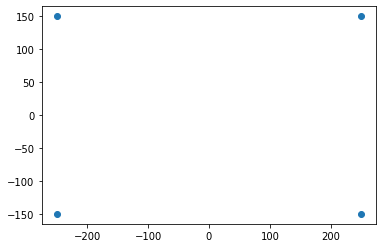

In [5]:
plt.figure()
plt.scatter(points[:,0], points[:,1])
plt.show()

## projecting points from 3D to 2D

In [6]:
intrinsics = np.loadtxt('calibration/intrinsics.txt')
distortion = np.loadtxt('calibration/distortion.txt')

print("Intrinsics are:" + str(intrinsics))
print("Distortion coefficients are:" + str(distortion))


Intrinsics are:[[664.6329766    0.         931.53151205]
 [  0.         663.83211807 520.64004697]
 [  0.           0.           1.        ]]
Distortion coefficients are:[-4.0929449e-01  2.1631278e-01  1.1120000e-05  1.2712000e-03
 -7.2057120e-02]


In [7]:
points_converted = convert_points_nx3_to_1xnx3(points)

rvec = np.zeros((1,3))
tvec = np.zeros((1,3))
image_points, jacobian = cv2.projectPoints(points_converted, rvec, tvec, intrinsics, distortion)

In [8]:
image_points = image_points.squeeze()
print(image_points)

[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]


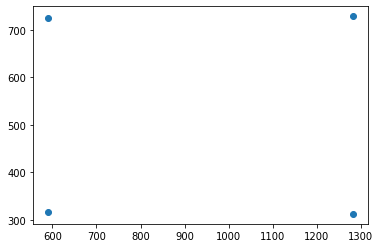

In [9]:
plt.figure()
plt.scatter(image_points[:,0], image_points[:,1])
plt.show()

# Simulation 1: adding noise to image points (2D)

In [10]:
# points-3D
# image_points-2D
# image_points_noisy-2D noisy

First we add noise to the image points (that is- add noise in 2D)

In [11]:
sigma=0.25
image_points_noisy = add_noise_to_points(image_points,sigma)

We then find the corresponding transformation to match the 2D image points to the corresponding 3D locations

In [12]:
success_true, rotation_vector_true, translation_vector_true = cv2.solvePnP(points.astype('float32'), image_points.astype('float32'), intrinsics, distortion, flags=0 )

success, rotation_vector, translation_vector = cv2.solvePnP(points.astype('float32'), image_points_noisy.astype('float32'), intrinsics, distortion, flags=0 )

if success_true:
    print(f'rotation true:, {rotation_vector_true}')
    print(f'translation true:, {translation_vector_true}')
else:
    print('solution not found')
    
if success:
    print(f'rotation:, {rotation_vector}')
    print(f'translation:, {translation_vector}')
else:
    print('solution not found')
    

        

rotation true:, [[-1.33849327e-04]
 [ 1.53026096e-02]
 [ 2.27516157e-07]]
translation true:, [[-2.08313803e+00]
 [-1.82287484e-02]
 [ 2.01168074e+02]]
rotation:, [[4.45433922e-04]
 [1.66332177e-02]
 [6.55360193e-05]]
translation:, [[-2.68617538e+00]
 [ 1.78282338e-01]
 [ 2.01222151e+02]]


Finally we project the 3D points to 2D with the true and noisy rotation and translation

In [13]:
point_projected2D_true, jacobian = cv2.projectPoints(points_converted, rotation_vector_true, translation_vector_true, intrinsics, distortion)
point_projected2D_true = point_projected2D_true.squeeze()
print(point_projected2D_true)

point_projected2D, jacobian = cv2.projectPoints(points_converted, rotation_vector, translation_vector, intrinsics, distortion)
point_projected2D = point_projected2D.squeeze()
print(point_projected2D)



[[ 590.71083943  315.32212628]
 [ 590.68341083  726.00576517]
 [1281.25122558  729.16991962]
 [1281.22322562  312.15831522]]
[[ 590.52949766  315.56528453]
 [ 590.60778371  725.85704025]
 [1280.97291228  729.43275618]
 [1281.10782153  312.0867723 ]]


We can also use this rotation and translation to transform any other point in this coordinate system- eg. a point where the caner is locaed


In [14]:
cancer_projected2D_true, jacobian = cv2.projectPoints(cancer_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
cancer_projected2D_true = cancer_projected2D_true.squeeze()
print(cancer_projected2D_true)

cancer_projected2D, jacobian = cv2.projectPoints(cancer_point, rotation_vector, translation_vector, intrinsics, distortion)
cancer_projected2D = cancer_projected2D.squeeze()
print(cancer_projected2D)


[924.64967063 520.57989916]
[922.66022744 521.22813891]


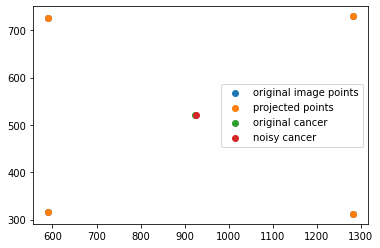

In [15]:
plt.figure()
plt.scatter(image_points[:,0], image_points[:,1])
plt.scatter(point_projected2D[:,0], point_projected2D[:,1])
#plt.scatter(image_points_noisy[:,0], image_points_noisy[:,1])

plt.scatter(cancer_projected2D[0], cancer_projected2D[1])
plt.scatter(cancer_projected2D_true[0], cancer_projected2D_true[1])

plt.legend(['original image points', 'projected points', 'original cancer', 'noisy cancer'])

plt.show()

Error in 3D

In [16]:
cancer_projected2D

success_true, rotation_vector_true, translation_vector_true = cv2.solvePnP(points.astype('float32'), image_points.astype('float32'), intrinsics, distortion, flags=0 )


In [17]:
print(f'cancer 3D true: {cancer_point}')
print(f'cancer 2D true: {cancer_projected2D_true}')
print(f'rotation true:, {rotation_vector_true}')
print(f'translation true:, {translation_vector_true}')

print(f'cancer 2D error: {cancer_projected2D}')
print(f'rotation:, {rotation_vector}')
print(f'translation:, {translation_vector}')


cancer 3D true: [[[0. 0. 0.]]]
cancer 2D true: [924.64967063 520.57989916]
rotation true:, [[-1.33849327e-04]
 [ 1.53026096e-02]
 [ 2.27516157e-07]]
translation true:, [[-2.08313803e+00]
 [-1.82287484e-02]
 [ 2.01168074e+02]]
cancer 2D error: [922.66022744 521.22813891]
rotation:, [[4.45433922e-04]
 [1.66332177e-02]
 [6.55360193e-05]]
translation:, [[-2.68617538e+00]
 [ 1.78282338e-01]
 [ 2.01222151e+02]]


In [18]:
# cancer_projected2D @ intrinsics.T
# intrinsics.T @ 


In [19]:

'''
original_undistorted = cv2.undistortPoints(cancer_projected2D, intrinsics, distortion)
noisy_undistorted = cv2.undistortPoints(cancer_projected2D_true, intrinsics, distortion)

t = translation_vector_true[:,0]
r = rotation_vector_true[:,0]

params = [t[0], t[1], t[2],r[0], r[1], r[2]]  

Q=rigid_body_parameters_to_matrix(params)

cv2.reprojectImageTo3D(cancer_projected2D, intrinsics)
'''

'\noriginal_undistorted = cv2.undistortPoints(cancer_projected2D, intrinsics, distortion)\nnoisy_undistorted = cv2.undistortPoints(cancer_projected2D_true, intrinsics, distortion)\n\nt = translation_vector_true[:,0]\nr = rotation_vector_true[:,0]\n\nparams = [t[0], t[1], t[2],r[0], r[1], r[2]]  \n\nQ=rigid_body_parameters_to_matrix(params)\n\ncv2.reprojectImageTo3D(cancer_projected2D, intrinsics)\n'

Investigating effects of different sigmas

when adding 2D noise, number of pxls off at sigma 0.12 is 0.7763930704692059
when adding 2D noise, number of pxls off at sigma 0.15 is 0.9609654131789737
when adding 2D noise, number of pxls off at sigma 0.25 is 1.6113716580025907


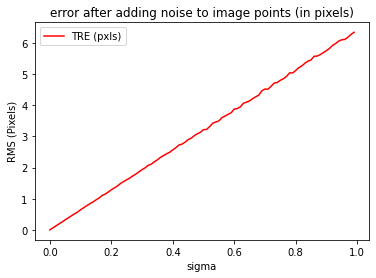

In [20]:

number_samples = 10000
x_values_px_1 = []
y_values_px_1 = []

x_values_mm = []
y_values_mm = []

for sigma_counter in range(0, 100, 1):
    sigma = float(sigma_counter) / float(100)
    rms = 0
    for i in range(number_samples):
        
        # add noise to image points
        image_points_noisy = add_noise_to_points(image_points,sigma)
        
        # try and match noisy 2D to original 3d object points
        # true
        success_true, rotation_vector_true, translation_vector_true = cv2.solvePnP(points.astype('float32'), image_points.astype('float32'), intrinsics,distortion, flags=0 )
        # noisy
        success, rotation_vector, translation_vector = cv2.solvePnP(points.astype('float32'), image_points_noisy.astype('float32'), intrinsics,distortion, flags=0 )

        
        # project cancer 3D point using the found rotations and translations
        # true
        point_projected2D_true, _ = cv2.projectPoints(cancer_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
        point_projected2D_true = point_projected2D_true.squeeze()
        # noisy
        point_projected2D, _ = cv2.projectPoints(cancer_point, rotation_vector, translation_vector, intrinsics, distortion)
        point_projected2D = point_projected2D.squeeze()

        # 3D noise
        
        #original_undistorted = cv2.undistortPoints(point_projected2D, intrinsics, distortion)
        #noisy_undistorted = cv2.undistortPoints(point_projected2D, intrinsics, distortion)

        
        euclid_dist_px =  (point_projected2D_true[0] - point_projected2D[0]) \
                     * (point_projected2D_true[0] - point_projected2D[0]) \
                     + (point_projected2D_true[1] - point_projected2D[1]) \
                     * (point_projected2D_true[1] - point_projected2D[1]) 
        
        
        #euclid_dist_mm = calculate_euclid_dist()
        
        rms = rms + euclid_dist_px
        
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    
    if sigma == 0.25:
        D2_25 = rms
        print(f'when adding 2D noise, number of pxls off at sigma {sigma} is {D2_25}')
    if sigma == 0.12:
        D2_12 = rms
        print(f'when adding 2D noise, number of pxls off at sigma {sigma} is {D2_12}')
    if sigma == 0.15:
        D2_15 = rms
        print(f'when adding 2D noise, number of pxls off at sigma {sigma} is {D2_15}')       
    x_values_px_1.append(sigma)
    y_values_px_1.append(rms)
    
plt.plot(x_values_px_1, y_values_px_1, 'r', label='TRE (pxls)')
plt.title('error after adding noise to image points (in pixels)')
plt.legend(loc='upper left')
plt.xlabel('sigma')
plt.ylabel('RMS (Pixels)')
plt.show()


## Simulation 2: adding noise to 3D


Add noise to the 3D points

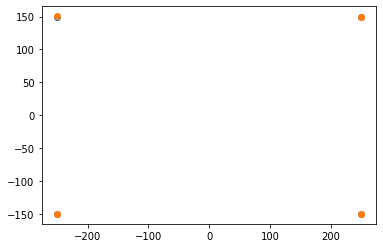

In [21]:
noisy_points = add_noise_to_points(points, 0.5)

plt.figure()
plt.scatter(points[:,0], points[:,1])
plt.scatter(noisy_points[:,0], noisy_points[:,1])
plt.show()


Project both noisy points and real points to 2D

In [22]:
image_points, _ = cv2.projectPoints(points_converted, rvec, tvec, intrinsics, distortion)
image_points_noisy, _ = cv2.projectPoints(noisy_points, rvec, tvec, intrinsics, distortion)
image_points = image_points.squeeze()
image_points_noisy = image_points_noisy.squeeze()

Find transformations to get from 3D to 2D

In [23]:
success_true, rotation_vector_true, translation_vector_true = cv2.solvePnP(points.astype('float32'), image_points.astype('float32'), intrinsics, distortion, flags=0 )

success, rotation_vector, translation_vector = cv2.solvePnP(noisy_points.astype('float32'), image_points_noisy.astype('float32'), intrinsics, distortion, flags=0 )


Use these transformations to transform a cancer

In [24]:
cancer_projected2D_true, _ = cv2.projectPoints(cancer_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
cancer_projected2D_true = cancer_projected2D_true.squeeze()
print(cancer_projected2D_true)

cancer_projected2D, _ = cv2.projectPoints(cancer_point, rotation_vector, translation_vector, intrinsics, distortion)
cancer_projected2D = cancer_projected2D.squeeze()
print(cancer_projected2D)

[924.64967063 520.57989916]
[918.36855316 532.15253859]


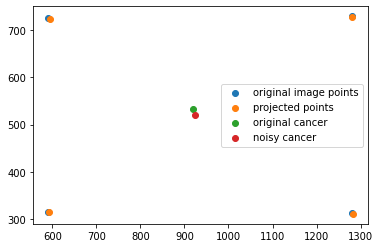

In [25]:
plt.figure()
plt.scatter(image_points[:,0], image_points[:,1])
plt.scatter(image_points_noisy[:,0], image_points_noisy[:,1])
#plt.scatter(image_points_noisy[:,0], image_points_noisy[:,1])

plt.scatter(cancer_projected2D[0], cancer_projected2D[1])
plt.scatter(cancer_projected2D_true[0], cancer_projected2D_true[1])

plt.legend(['original image points', 'projected points', 'original cancer', 'noisy cancer'])

plt.show()

when adding 3D noise, number of pxls off at sigma 0.12 is 4.6146311972532725
when adding 3D noise, number of pxls off at sigma 0.15 is 5.729111436847025
when adding 3D noise, number of pxls off at sigma 0.25 is 9.482135381604849


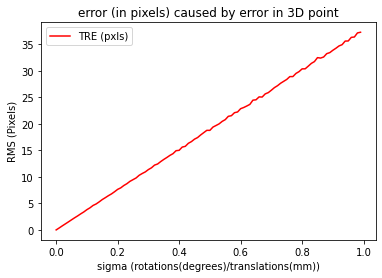

In [26]:

number_samples = 10000
x_values_px_2 = []
y_values_px_2 = []

x_values_mm = []
y_values_mm = []

for sigma_counter in range(0, 100, 1):
    sigma = float(sigma_counter) / float(100)
    rms = 0
    for i in range(number_samples):
        
        # add noise to 3D points
        noisy_points = add_noise_to_points(points, sigma)
        
        # project both noisy and non-noisy 3D points to 2D
        image_points, _ = cv2.projectPoints(points_converted, rvec, tvec, intrinsics, distortion)
        image_points_noisy, _ = cv2.projectPoints(noisy_points, rvec, tvec, intrinsics, distortion)
        image_points = image_points.squeeze()
        image_points_noisy = image_points_noisy.squeeze()
    
        
        # try and match noisy 2D to original 3d object points and get transformation
        # true
        success_true, rotation_vector_true, translation_vector_true = cv2.solvePnP(points.astype('float32'), image_points.astype('float32'), intrinsics, distortion, flags=0 )
        # noisy
        success, rotation_vector, translation_vector = cv2.solvePnP(noisy_points.astype('float32'), image_points_noisy.astype('float32'), intrinsics, distortion, flags=0 )
        
        # project cancer 3D point using the found rotations and translations
        # true
        cancer_projected2D_true, _ = cv2.projectPoints(cancer_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
        cancer_projected2D_true = cancer_projected2D_true.squeeze()
        # noisy
        cancer_projected2D, _ = cv2.projectPoints(cancer_point, rotation_vector, translation_vector, intrinsics, distortion)
        cancer_projected2D = cancer_projected2D.squeeze()

        
        euclid_dist_px =  (cancer_projected2D_true[0] - cancer_projected2D[0]) \
                     * (cancer_projected2D_true[0] - cancer_projected2D[0]) \
                     + (cancer_projected2D_true[1] - cancer_projected2D[1]) \
                     * (cancer_projected2D_true[1] - cancer_projected2D[1]) 
        
        
        #euclid_dist_mm = calculate_euclid_dist()
        
        rms = rms + euclid_dist_px
        
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    
    if sigma == 0.25:
        D3_25 = rms
        print(f'when adding 3D noise, number of pxls off at sigma {sigma} is {D3_25}')
    if sigma == 0.12:
        D3_12 = rms
        print(f'when adding 3D noise, number of pxls off at sigma {sigma} is {D3_12}')
    if sigma == 0.15:
        D3_15 = rms
        print(f'when adding 3D noise, number of pxls off at sigma {sigma} is {D3_15}')
                    
        
    x_values_px_2.append(sigma)
    y_values_px_2.append(rms)
    
plt.plot(x_values_px_2, y_values_px_2, 'r', label='TRE (pxls)')
plt.title('error (in pixels) caused by error in 3D point')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('RMS (Pixels)')
plt.show()


## Simulation 3: adding noise to both

when adding 3D noise and 2D noise, number of pxls off at sigma 0.12 is 4.629484376832195
when adding 3D noise and 2D noise, number of pxls off at sigma 0.15 is 5.741507783589586
when adding 3D noise and 2D noise, number of pxls off at sigma 0.25 is 9.598804247195247


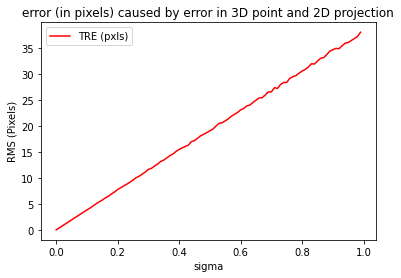

In [28]:

number_samples = 10000
x_values_px_3 = []
y_values_px_3 = []

x_values_mm = []
y_values_mm = []

for sigma_counter in range(0, 100, 1):
    sigma = float(sigma_counter) / float(100)
    rms = 0
    for i in range(number_samples):
        
        # add noise to 3D points
        noisy_points = add_noise_to_points(points, sigma)
        
        # project both noisy and non-noisy 3D points to 2D
        image_points, _ = cv2.projectPoints(points_converted, rvec, tvec, intrinsics, distortion)
        image_points_noisy, _ = cv2.projectPoints(noisy_points, rvec, tvec, intrinsics, distortion)
        image_points = image_points.squeeze()
        image_points_noise_3D = image_points_noisy.squeeze()
        #print(image_points_noise_3D)
        # add noise to 2D points
        image_points_noisy = add_noise_to_points(image_points_noise_3D,sigma)
        #print(image_points_noisy)
        
        # try and match noisy 2D to original 3d object points and get transformation
        # true
        success_true, rotation_vector_true, translation_vector_true = cv2.solvePnP(points.astype('float32'), image_points.astype('float32'), intrinsics, distortion, flags=0 )
        # noisy
        success, rotation_vector, translation_vector = cv2.solvePnP(noisy_points.astype('float32'), image_points_noisy.astype('float32'), intrinsics, distortion, flags=0 )
        
        # project cancer 3D point using the found rotations and translations
        # true
        cancer_projected2D_true, _ = cv2.projectPoints(cancer_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
        cancer_projected2D_true = cancer_projected2D_true.squeeze()
        # noisy
        cancer_projected2D, _ = cv2.projectPoints(cancer_point, rotation_vector, translation_vector, intrinsics, distortion)
        cancer_projected2D = cancer_projected2D.squeeze()

        
        euclid_dist_px =  (cancer_projected2D_true[0] - cancer_projected2D[0]) \
                     * (cancer_projected2D_true[0] - cancer_projected2D[0]) \
                     + (cancer_projected2D_true[1] - cancer_projected2D[1]) \
                     * (cancer_projected2D_true[1] - cancer_projected2D[1]) 
        
        
        #euclid_dist_mm = calculate_euclid_dist()
        
        rms = rms + euclid_dist_px
        
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    
    if sigma == 0.25:
        D3D2_25 = rms
        print(f'when adding 3D noise and 2D noise, number of pxls off at sigma {sigma} is {D3D2_25}')
    if sigma == 0.12:
        D3D2_12 = rms
        print(f'when adding 3D noise and 2D noise, number of pxls off at sigma {sigma} is {D3D2_12}')
    if sigma == 0.15:
        D3D2_15 = rms
        print(f'when adding 3D noise and 2D noise, number of pxls off at sigma {sigma} is {D3D2_15}')
            
    x_values_px_3.append(sigma)
    y_values_px_3.append(rms)
    
plt.plot(x_values_px_3, y_values_px_3, 'r', label='TRE (pxls)')
plt.title('error (in pixels) caused by error in 3D point and 2D projection')
plt.legend(loc='upper left')
plt.xlabel('sigma')
plt.ylabel('RMS (Pixels)')
plt.show()


In [ ]:
image_points_noisy

In [ ]:
add_noise_to_points(image_points_noisy, 0.5)

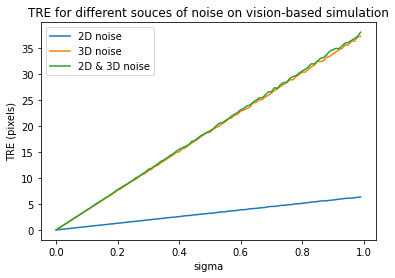

In [30]:

plt.figure()
plt.xlabel('sigma')
plt.ylabel('TRE (pixels)')
plt.title('TRE for different souces of noise on vision-based simulation')


plt.plot(x_values_px_1, y_values_px_1, label='2D noise')
plt.plot(x_values_px_2, y_values_px_2, label='3D noise')
plt.plot(x_values_px_3, y_values_px_3, label='2D & 3D noise')
plt.legend()
plt.show()